In [1]:
from typing import List
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F

%config InlineBackend.figure_format = 'retina'

### Load and summarize the data

In [2]:
seqs = pd.read_csv("oas_pair_heavy.csv", usecols=["cdr3_aa_heavy"])[
    "cdr3_aa_heavy"
].tolist()
seqs = list(set(seqs))
seqs[:10]

['ARQAVPGNHFDY',
 'ARSSYGNLAWFAY',
 'ARLGLVPIASNWFDP',
 'ARGFDGSGNYARLTFDY',
 'TRYYYGSSFAY',
 'ARNGRGFDY',
 'ARSSPTVVTGYYWYFDF',
 'TRERMGDWFAY',
 'ARRIYGSRNWFAY',
 'ARIASPYYYDGTYSYYFDY']

95% CI: [6.000, 22.000]
101344 sequences, min length 2, max length 44


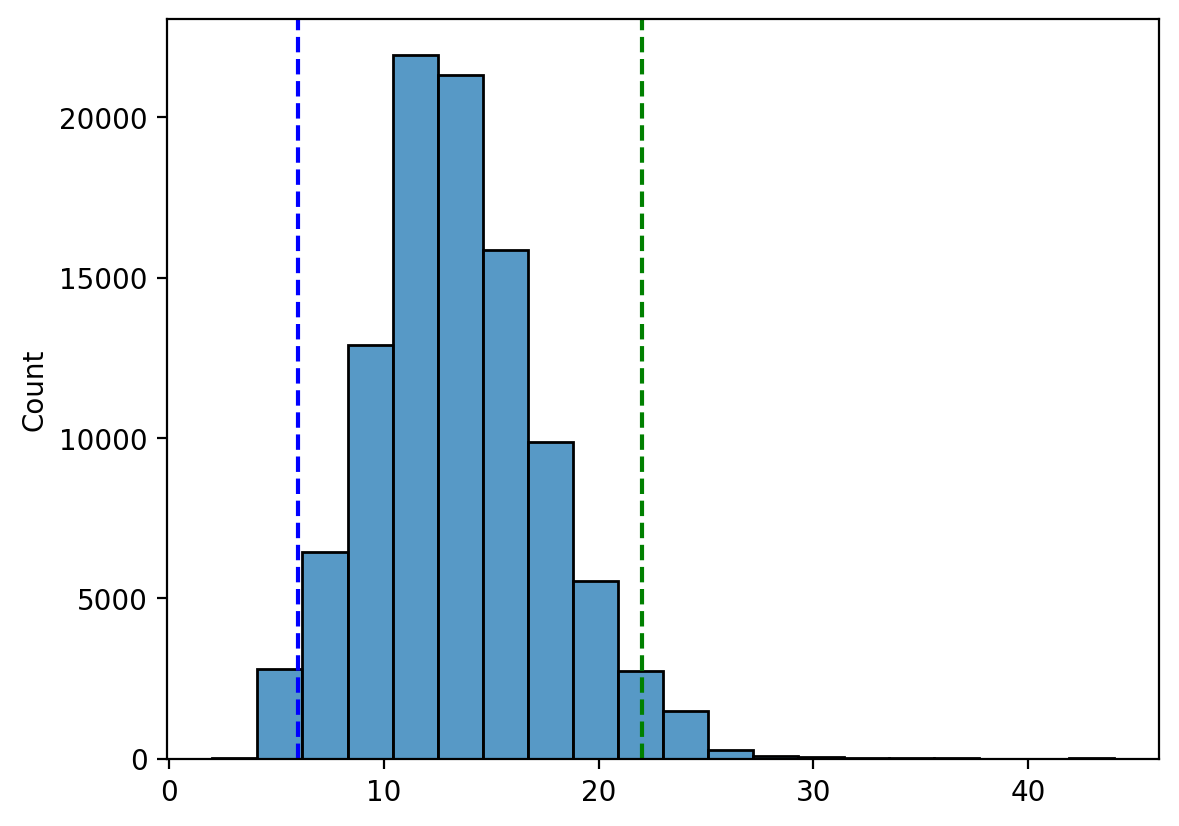

In [3]:
lengths = [len(seq) for seq in seqs]
total = len(seqs)
min_len = min(lengths)
max_len = max(lengths)
lower = np.percentile(lengths, 2.5)
upper = np.percentile(lengths, 97.5)
print(f"95% CI: [{lower:.3f}, {upper:.3f}]")
print(f"{total} sequences, min length {min_len}, max length {max_len}")
sns.histplot(lengths, bins=20, kde=False, stat="count")
plt.axvline(lower, color="blue", linestyle="--", label="2.5% (Lower)")
plt.axvline(upper, color="green", linestyle="--", label="97.5% (Upper)")
plt.show()

### Vocabulary and mapper

In [4]:
tokens = sorted(list(set("".join(seqs))))
stoi = {t: i+1 for i, t in enumerate(tokens)}
stoi['.'] = 0
itos = {i: t for t, i in stoi.items()}

### Dataset

In [27]:
def build_dataset(splits, n=3):
    X, Y = [], []
    for seq in splits:
        context = '.' * n
        seq = context + seq + '.'
        for i in range(len(seq) - n):
            input_tokens = seq[i: i+n]
            target_token = seq[i+n]
            input_ids = [stoi[token] for token in input_tokens]
            target_id = stoi[seq[i+n]]
            # print(f"{input_ids}|{input_tokens} ==> {target_id}|{target_token}")
            X.append(input_ids)
            Y.append(target_id)

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [28]:
# Train,  Validation, Test
random.seed(42)
random.shuffle(seqs)
n1 = int(0.8*len(seqs))
n2 = n1 + int(0.5*(len(seqs) - n1))
X_train, Y_train = build_dataset(seqs[:n1])
X_val, Y_val = build_dataset(seqs[n1:n2])
X_test, Y_test = build_dataset(seqs[n2:])

### Hyperparameters

In [213]:
embedding_dim = 2
window_size = 3
hidden_dim = 300

In [214]:
g = torch.Generator().manual_seed(222)

### Model

In [215]:
print(f"Input Shape: [..., {window_size}]")
C = torch.randn(len(stoi), embedding_dim, generator=g, requires_grad=True)

W1 = torch.randn(window_size * embedding_dim, hidden_dim, generator=g, requires_grad=True)
b1 = torch.randn(hidden_dim, generator=g, requires_grad=True)

W2 = torch.randn(hidden_dim, len(stoi), generator=g, requires_grad=True)
b2 = torch.randn(len(stoi), generator=g, requires_grad=True)

print(f"Lookup Table Shape: {C.shape}")
print(f"W1 Shape: {W1.shape}, b1 Shape: {b1.shape}")
print(f"W2 Shape: {W2.shape}, b2 Shape: {b2.shape}")

Input Shape: [..., 3]
Lookup Table Shape: torch.Size([21, 2])
W1 Shape: torch.Size([6, 300]), b1 Shape: torch.Size([300])
W2 Shape: torch.Size([300, 21]), b2 Shape: torch.Size([21])


In [216]:
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

8463

### Training

In [217]:
steps = 30000
batch_size = 128

In [218]:
# # Used for find best learning rate
# lr_range = [0.001, 0.5]
# min_lre = math.log10(lr_range[0])
# max_lre = math.log10(lr_range[1])
# lre = torch.linspace(min_lre, max_lre, steps)
# lrs = 10 ** lre
# lrs

In [219]:
losses = []
learning_rates = []
track_steps = []

In [220]:
for step in range(steps):
    indices = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch = X_train[indices]
    Y_batch = Y_train[indices]
    # Forward
    embed = C[X_batch]
    h = torch.tanh(embed.view(-1, embedding_dim * window_size) @ W1 + b1)
    logits = h @ W2 + b2
    # probs = logits.exp()
    # probs /= probs.sum(1, keepdim=True)

    # Loss
    loss = F.cross_entropy(logits, Y_batch)

    # Backward
    for p in parameters:
        p.grad = None

    loss.backward()

    # lr = lrs[step]
    lr = 10 ** (-2)

    for p in parameters:
        p.data += -lr * p.grad
    
    losses.append(loss.item())
    track_steps.append(step)
    # learning_rates.append(lre[step])

    if step % 100 == 0:
        print(f"Step: {step} | Loss: {loss.item():.4f}")
    
    if loss.item() <= 2.27:
        break

print(f"Final Loss: {loss.item()}")

Step: 0 | Loss: 33.2558
Step: 100 | Loss: 12.6038
Step: 200 | Loss: 7.8501
Step: 300 | Loss: 5.5309
Step: 400 | Loss: 4.2385
Step: 500 | Loss: 3.7668
Step: 600 | Loss: 3.0896
Step: 700 | Loss: 3.1502
Step: 800 | Loss: 3.5173
Step: 900 | Loss: 2.4536
Step: 1000 | Loss: 2.7403
Step: 1100 | Loss: 2.7797
Final Loss: 2.217202663421631


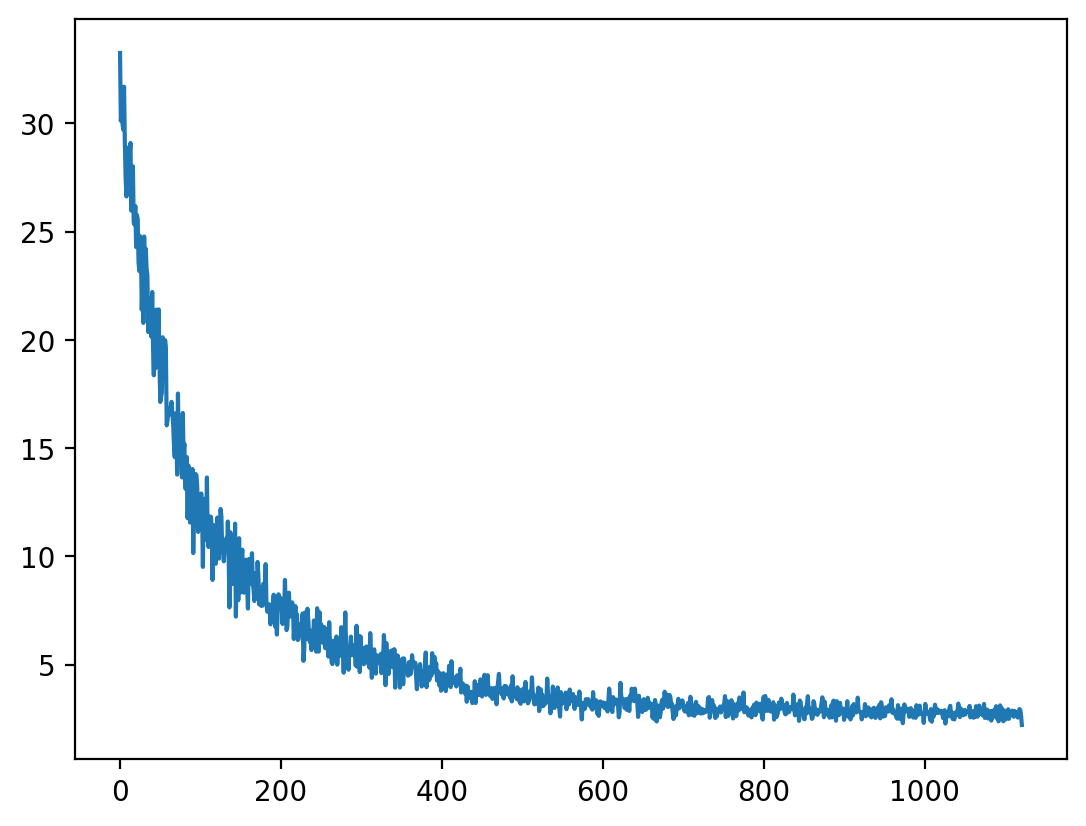

In [221]:
plt.plot(track_steps, losses)

In [222]:
# plt.plot(learning_rates, losses)

In [223]:
embed = C[X_train]
h = torch.tanh(embed.view(-1, window_size * embedding_dim) @ W1 + b1)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, Y_train)
print(train_loss.item())

2.704721450805664


### Validation

In [224]:
embed = C[X_val]
h = torch.tanh(embed.view(-1, window_size * embedding_dim) @ W1 + b1)
logits = h @ W2 + b2
val_loss = F.cross_entropy(logits, Y_val)
print(val_loss.item())

2.7124595642089844


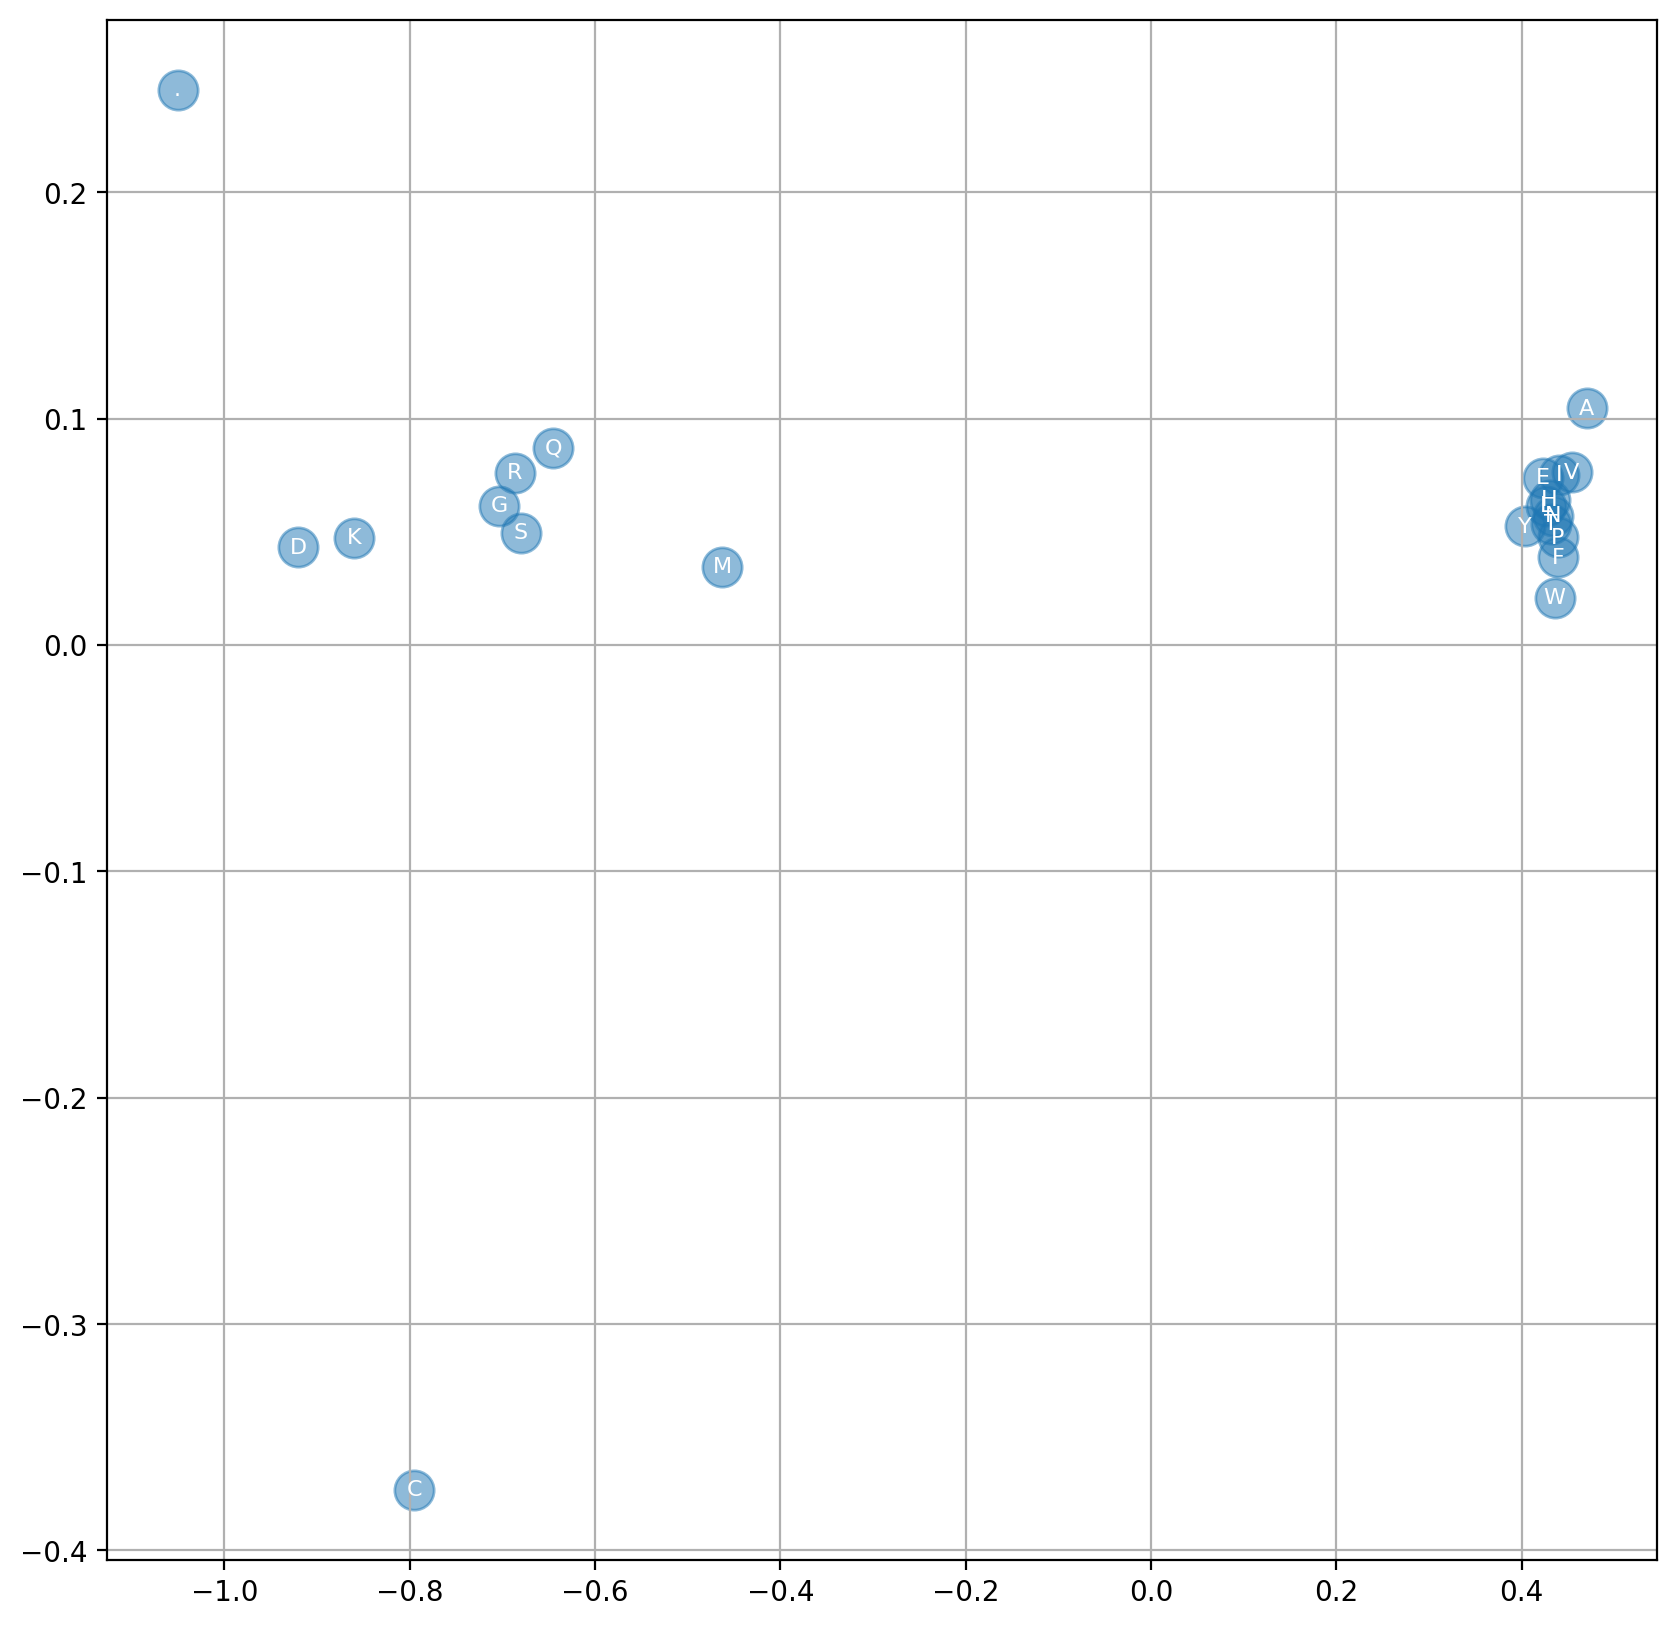

In [225]:
plt.figure(figsize=(10, 10))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200, alpha=0.5)
for i in range(C.shape[0]):
	plt.text(C[i, 0].data, C[i, 1].data, itos[i], ha='center', va='center', color='white', 
		  fontdict={'fontsize': 8})
plt.grid()
plt.show()

### Generate

In [255]:
def sampling_one_seq(start_seq='...', generator=None, end_token='.'):
    sampled_seq = start_seq
    i = 0
    while True:
        with torch.no_grad():
            context_seq = sampled_seq[i:i+window_size]
            input_ids = torch.tensor([stoi[s] for s in context_seq])
            # forward
            embed = C[input_ids]
            h = torch.tanh(embed.view(-1, window_size * embedding_dim) @ W1 + b1)
            logits = h @ W2 + b2
            probs = logits.exp()
            probs /= probs.sum(1, keepdim=True)
            ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=generator).item()
            sampled_seq += itos[ix]
            i += 1
            if ix == stoi[end_token]:
                break
    return sampled_seq[3:-1]


In [256]:
generator = torch.Generator().manual_seed(443)
sampling_one_seq(start_seq='...', generator=generator, end_token='.')

'ARDYFEYDARQFSYDP'

In [257]:
def sampling_batch_seqs(
    sample_size=10, seed=2147483647
):
    generator = torch.Generator().manual_seed(seed)
    sampled_seqs = []

    for i in range(sample_size):
        sampled_seq = sampling_one_seq(start_seq='...', generator=generator, end_token='.')
        sampled_seqs.append(sampled_seq)
    return sampled_seqs

In [260]:
sampling_batch_seqs(sample_size=20)

['ARTRGSYGGRWGGISDGFKV',
 'ARQGSVGYTEWSY',
 'APSFMGGDYALVWDY',
 'ARYMGL',
 'ARDDYGWYRGWYKGLPFYFGGAARVFIGDVADLFFGQGYKVRGEAYDYYFEY',
 'ARQEYRPTAA',
 'AAWFWFYYTQLLSL',
 'AKDARFPNDGEGYSVGYLWDYGEINDV',
 'ASGYFYWLYYA',
 'AREGP',
 'AFLRPDYGG',
 'ARF',
 'ARDDHDY',
 'ARSTSYYQGAFDSGTDYRGYFDYMFLNVDY',
 'AASYFSYRGEPNY',
 'TIMRGSSVGYGGARFLAMGGI',
 'ARDARGYLMRFDYGSSSGAGGRFAAYTGP',
 'AIV',
 'ARRA',
 'AADV']